------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis/blob/main/code.ipynb)__ 
------------------------------------------------------------------------------------------------------------------------

In [18]:
#this line imports the functions needed for this project
%run code.ipynb


# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [19]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [20]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (simple_common_stations(simple_common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['01639', '05792', '00656', '01550', '01691', '00691', '02014', '05100', '00867', '03032', '01975', '05906', '03631', '02601', '02290', '04887', '02261', '02597', '05705', '05371', '00701', '04371', '04104', '03730']


### Let's plot the stations to make sure that the points are representative for whole Germany:

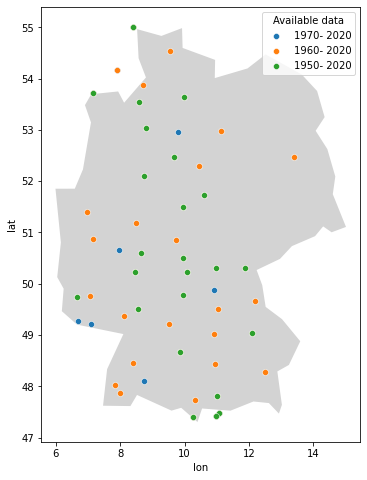

In [21]:
plot_points_germany()

#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

## Step 2. Results
### 1. Temperature

In [22]:
df_airtemp = create_df("air_temperature","hourly",1950,2019,ids = common_ids, is_test=False)
#Replacing non-existent values
df_airtemp.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


(0.0, 300000.0)

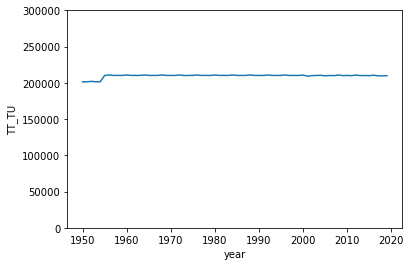

In [24]:
#Step 1. Checking data integrity:

df = df_airtemp.copy()
measures = df.groupby("year").count()
fig = plt.figure()
ax = sns.lineplot(x=measures.index,y=measures.TT_TU)
ax.set_ylim(bottom = 0, top = 300000)


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

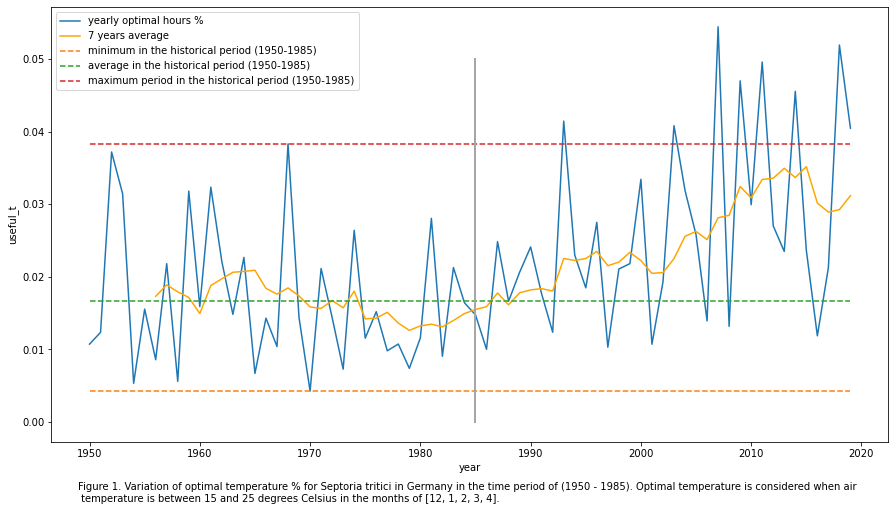

In [25]:
plot_optimal_temperature(df_airtemp, temp_min=15,temp_max=25,hist_start=1950,hist_end=1985,months=[12,1,2,3,4], moving_average=7)

I will try now to attempt to model using CO2 emmisions:

https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions

### 2. Leaf wetness

In [26]:
df_moisture= create_df("moisture","hourly",1950,2019,ids = common_ids, is_test=False)

#Replacing non-existent values
df_moisture.replace(-99.9, np.nan, inplace=True)

All given ids accounted for


Text(0, 0.5, 'Number of measures')

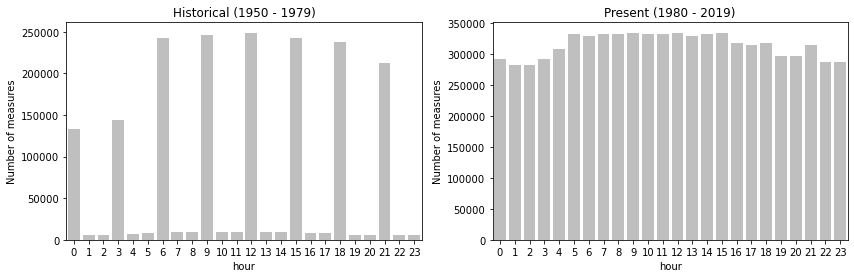

In [27]:
hist_moisture = df_moisture[df_moisture["year"]<1980].groupby("hour").count()
recent_moisture = df_moisture[df_moisture["year"]>=1980].groupby("hour").count()

fig, ax =plt.subplots(1,2,figsize=(14,4))
sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
ax[0].set_title("Historical (1950 - 1979)")
ax[1].set_title("Present (1980 - 2019)")
ax[0].set_ylabel("Number of measures")
ax[1].set_ylabel("Number of measures")

We can observe from here that in this time period, the relative humidity was mostly measured from 3 to 3 hours, during the working time, as the measuring process was mostly manual.
From 1980, the data is measured more constantly. The variation in the RH analysis comes from here.

### Now let's try to plot it only for the hours where we have the measurement value correct

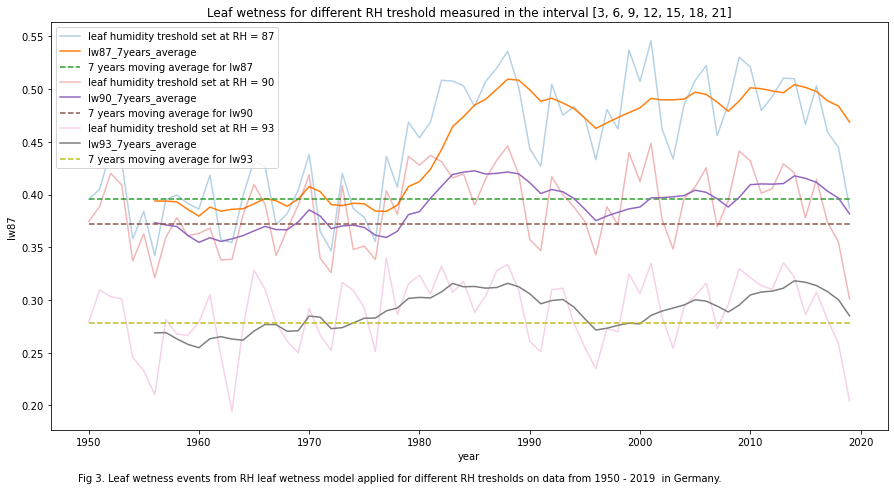

In [28]:
plot_lw_RHt(df_moisture,
            thresholds=[87,90,93],
            hist_start=1950,hist_end=1979, 
            months=[12,1,2,3,4],moving_average=7,
            hours=[3,6,9,12,15,18,21]
            )

### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

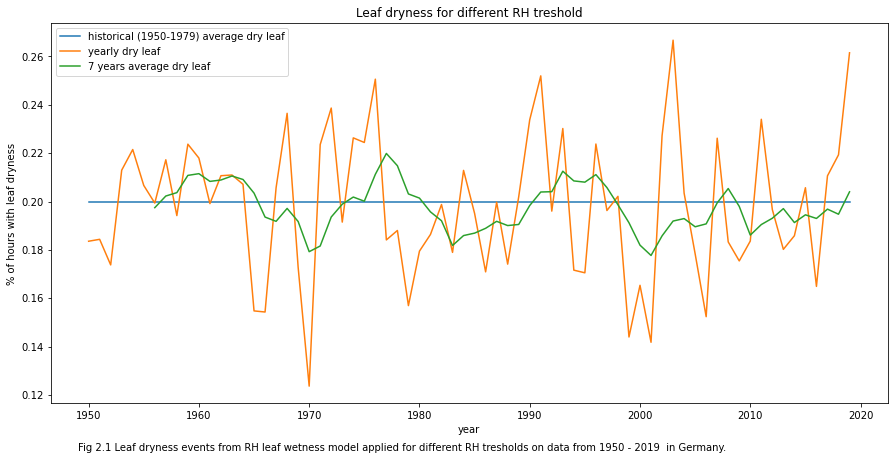

In [29]:
df3_dryness = df_moisture[df_moisture["month"].isin([12,1,2,3,4])]

df3_dryness[f"dry_leaf"]=df3_dryness["RF_STD"].apply(lambda x: 1 if float(x) <= 70 else 0)
df3_dryness= df3_dryness.groupby("year").mean()
df3_dryness['7yrs_average'] = df3_dryness.dry_leaf.rolling(7).mean()
avg50_79= df3_dryness[df3_dryness.index <= 1979]["dry_leaf"].mean()

plt.figure(figsize = (15,7))
sns.lineplot( x=df3_dryness.index, y = avg50_79 , label = "historical (1950-1979) average dry leaf")
sns.lineplot( x="year", y = "dry_leaf", data= df3_dryness, label = "yearly dry leaf")
sns.lineplot( x="year", y = '7yrs_average', data= df3_dryness, label = "7 years average dry leaf")
plt.title("Leaf dryness for different RH treshold")
plt.ylabel("% of hours with leaf dryness")
plt.figtext(0.15, 0.031, "Fig 2.1 Leaf dryness events from RH leaf wetness model applied for different RH tresholds on data from 1950 - 2019  in Germany." )
plt.show()

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [38]:
df_dew_point = create_df("dew_point","hourly",1950,2020,ids = common_ids, is_test=False)

#Replacing unknown values with np.nan so they will not be counted in the statistic
df_dew_point.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


<AxesSubplot:xlabel='year', ylabel='TD'>

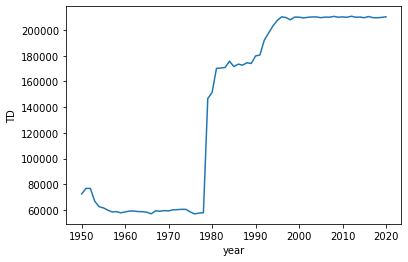

In [40]:
#Checking data integrity and quality
df_dpd = df_dew_point.copy()
measures = df_dpd.groupby("year").count()
sns.lineplot(x=measures.index,y=measures.TD)

Again, I can not apply the model and look for consecutive times with leaf wetness because until 1990 the dew point is measured every 3 hours. But we can work with %.

In [41]:

df_dpd["difference"]=df_dpd.apply(lambda x: (x['TT']- x['TD']), axis=1)
df_dpd= df_dpd[df_dpd["month"].isin([12,1,2,3,4])]
df_dpd = df_dpd.groupby("year").mean()
avg50_79= df_dpd[df_dpd.index <= 1979]["difference"].mean()
max50_79 = df_dpd[df_dpd.index <= 1979]["difference"].max()
min50_79 = df_dpd[df_dpd.index <= 1979]["difference"].min()
df_dpd['7yrs_average'] = df_dpd.difference.rolling(7).mean()

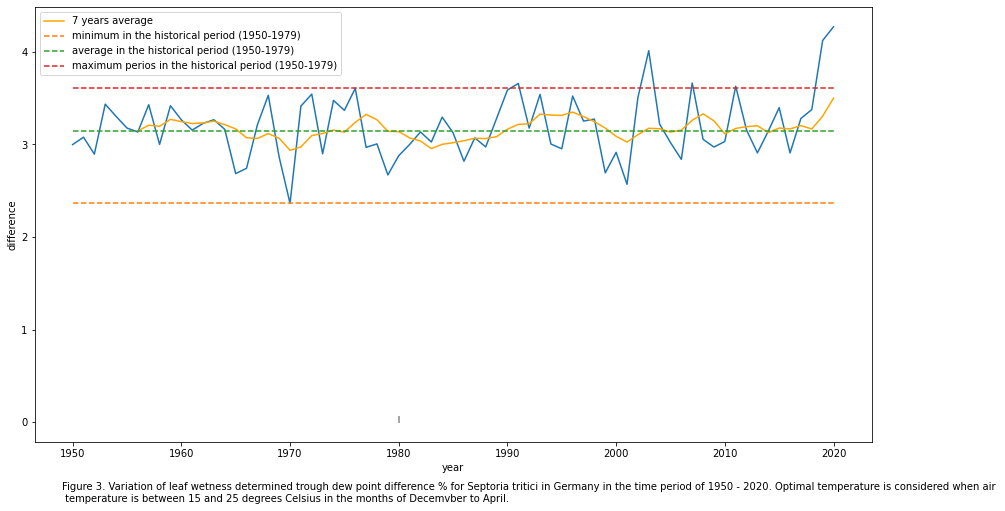

In [42]:

plt.figure(figsize = (15,8))

sns.lineplot(x=df_dpd.index, y= df_dpd["difference"])#, label = "average yearly difference")
sns.lineplot(x = df_dpd.index, y = df_dpd['7yrs_average'], label="7 years average", color = "orange")
sns.lineplot(x = df_dpd.index, y = min50_79,linestyle="dashed", label="minimum in the historical period (1950-1979)")
sns.lineplot(x = df_dpd.index, y = avg50_79,linestyle="dashed", label="average in the historical period (1950-1979)")
sns.lineplot(x = df_dpd.index, y = max50_79, linestyle="dashed", label="maximum perios in the historical period (1950-1979)")

plt.plot([1980,1980], [-0.00,0.05], lw=2, color = "0.65", label = "historical period (left)")


plt.figtext(0.15, 0.021, "Figure 3. Variation of leaf wetness determined trough dew point difference % for Septoria tritici in Germany in the time period of 1950 - 2020. Optimal temperature is considered when air \n temperature is between 15 and 25 degrees Celsius in the months of Decemvber to April. " )
plt.show()

In [43]:
df_dpd = df4.copy()
